In [100]:
# Importing required libraries
import pandas as pd
from nltk.corpus import stopwords
from nltk import pos_tag, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
import seaborn as sns
from numba import jit
from textblob import TextBlob, classifiers

In [2]:
# Reading the dataset
column = ['Target', 'Id', 'DateTime', 'Flag', 'User', 'Tweet']

df = pd.read_csv(r'Data/TrainingDataset.csv', names=column)

In [3]:
df.head()

,Target,Id,DateTime,Flag,User,Tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# Checking for Null values
df.isnull().any()

Target      False
Id          False
DateTime    False
Flag        False
User        False
Tweet       False
dtype: bool

In [5]:
# Checking for duplicate values
df.duplicated().any()

False

In [6]:
df.drop(columns=['DateTime', 'Id', 'Flag', 'User'], axis=1, inplace=True)

In [7]:
df.shape

(1600000, 2)

In [8]:
df['Target'].replace(4, 1, inplace=True)

In [9]:
df

,Target,Tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [10]:
# Lowering all the strings in dataframe
df['Cleaned_tweet'] = df['Tweet'].str.lower()

C:\Users\asp99\AppData\Local\Temp\ipykernel_8024\2032450690.py:4: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
C:\Users\asp99\AppData\Local\Temp\ipykernel_8024\2032450690.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "plot" failed type inference due to: Untyped global name 'df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "..\..\..\AppData\Local\Temp\ipykernel_8024\2032450690.py", line 7:
<source missing, REPL/exec in use?>

  @jit
c:\Users\asp99\OneDrive\Documents\SentimentAnalysis\venv\Lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWarning: Function "plot" was co

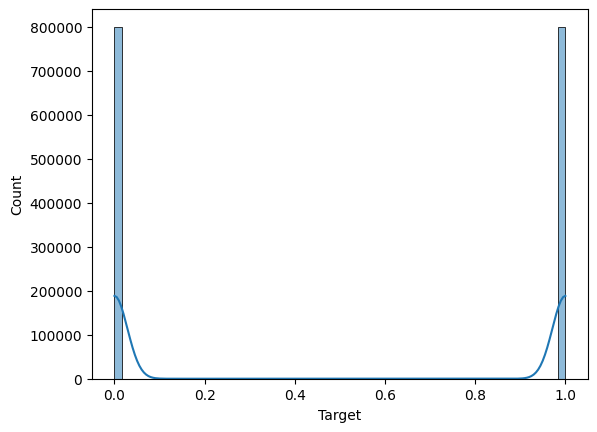

In [87]:
@jit
def plot():
    sns.histplot(df['Target'], kde=True)
plot()

In [12]:
df.drop(columns='Tweet', inplace=True)

In [13]:
# Replacing all the user id's into @user
df['Cleaned_tweet'] = df['Cleaned_tweet'].replace(regex='@[a-zA-Z_0-9]*', value='@user')

In [14]:
df_pos = df[df['Target'] == 1]
df_neg = df[df['Target'] == 0]

In [15]:
# Removing few records for the model to learn easily
df_pos = df_pos.iloc[0:20000]
df_neg = df_neg.iloc[0:20000]

In [16]:
df_neg

,Target,Cleaned_tweet
0,0,"@user http://twitpic.com/2y1zl - awww, that's ..."
1,0,is upset that he can't update his facebook by ...
2,0,@user i dived many times for the ball. managed...
3,0,my whole body feels itchy and like its on fire
4,0,"@user no, it's not behaving at all. i'm mad. w..."
...,...,...
19995,0,"not much time off this weekend, work trip to m..."
19996,0,one more day of holidays
19997,0,feeling so down right now .. i hate you damn h...
19998,0,"geez,i hv to read the whole book of personalit..."


In [17]:
df_pos

,Target,Cleaned_tweet
800000,1,i love @user u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@user thanks for the twitter add, sunisa! i go..."
800003,1,being sick can be really cheap when it hurts t...
800004,1,@user he has that effect on everyone
...,...,...
819995,1,we just met some awesome people at t.g.i fridays
819996,1,oh my goodness . my feet are the most sensitiv...
819997,1,@user hahaha
819998,1,@user pfft school is koo. i'm ranked 2nd in my...


In [18]:
data = pd.concat([df_neg, df_pos])
data.sample(20)

,Target,Cleaned_tweet
808353,1,@user heeey hola !
813874,1,the darling got stumbled
811350,1,@user the irony is that i use it every day at ...
813087,1,thinking of what to put on twitter
10191,0,@user 1 hand clapping is the usual reaction to...
11477,0,"len(reversed([1,2,3])) == 3 in py 2.5 and 2.6...."
18985,0,still out of the &quot;real&quot; world... no ...
807083,1,good morning! with apologies to my mstate fri...
15748,0,@user i'll be cheking on youtube after the sho...
18153,0,everyone flaked on me so i'm stuck at home


In [20]:
# Removing Stopwords
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

data['Cleaned_tweet'] = data['Cleaned_tweet'].apply(lambda x: remove_stopwords(x))

In [21]:
# Removing Punctuations
PUNCT = ['.', ',', '?', '!', '=', '&', ';', ':', '@', '-', '_', '(', ')', '[', ']', '{', '}', '"', "'"]
pattern = '''[-_.,;:'"\/=&@*)(}{?]'''

def remove_punct(text):
    return ' '.join([word for word in text.split() if word in re.sub(pattern=pattern, string=text, repl='')])

data['Cleaned_tweet'] = data['Cleaned_tweet'].apply(lambda x : remove_punct(x))

In [24]:
data.iloc[10:30]

,Target,Cleaned_tweet
10,0,spring break plain snowing
11,0,ears
12,0,bear watch thought ua loss embarrassing
13,0,idk never talk anymore
14,0,really zac
15,0,wish got watch you!! miss
16,0,death scene hurt severely watch film wry direc...
17,0,file taxes
18,0,ahh ive always wanted see rent love soundtrack!!
19,0,oh drinking forgotten table


In [25]:
# Parts of Speech tagging
pos_tag(data['Cleaned_tweet'])

[('shoulda got david carr third day', 'JJ'),
 ('upset update facebook texting might cry result school today blah!', 'JJ'),
 ('dived many times managed save 50% rest go bounds', 'NNS'),
 ('whole body feels itchy like fire', 'VBP'),
 ('behaving see', 'NN'),
 ('whole crew', 'NN'),
 ('need hug', 'JJ'),
 ('hey long time see! rains bit bit lol fine thanks', 'NNS'),
 ('nope', 'VBP'),
 ('que muera', 'NN'),
 ('spring break plain snowing', 'NN'),
 ('ears', 'NNS'),
 ('bear watch thought ua loss embarrassing', 'VBG'),
 ('idk never talk anymore', 'RB'),
 ('really zac', 'JJ'),
 ('wish got watch you!! miss', 'JJ'),
 ('death scene hurt severely watch film wry directors cut', 'NN'),
 ('file taxes', 'NNS'),
 ('ahh ive always wanted see rent love soundtrack!!', 'VBP'),
 ('oh drinking forgotten table', 'JJ'),
 ('day get much done', 'NN'),
 ('one friend called asked meet mid valley time', 'NN'),
 ('baked cake ated', 'VBN'),
 ('week going hoped', 'VBD'),
 ('blagh class 8 tomorrow', 'JJ'),
 ('hate call wake 

In [26]:
# Lemmetization
lem = WordNetLemmatizer()
def lemmat(text):
    return ' '.join([lem.lemmatize(x) for x in text.split()])

data['Lem_Tweet'] = data['Cleaned_tweet'].apply(lambda x: lemmat(x))

In [27]:
data.drop(columns='Cleaned_tweet', inplace=True)

In [29]:
# Bag Of Words
bow = CountVectorizer(stop_words='english', max_features=1500, max_df=0.9)
bow_array = bow.fit_transform(data['Lem_Tweet']).toarray()

In [30]:
bow_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [31]:
X = bow_array
y = data['Target'].values

In [32]:
X.shape, y.shape

((40000, 1500), (40000,))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=12)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32000, 1500), (8000, 1500), (32000,), (8000,))

Naive Bayes

In [35]:
naive = GaussianNB()
naive.fit(X_train, y_train)

GaussianNB()

In [36]:
naive_y_pred = naive.predict(X_test)
naive_y_pred

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [37]:
naive_acc = accuracy_score(y_test, naive_y_pred)
print('Accuracy score of Naive Bayes model : {}%'.format(naive_acc*100))

Accuracy score of Naive Bayes model : 66.75%


In [38]:
naive_conf = confusion_matrix(y_test, naive_y_pred)
print('Confusion Matrix of Naive Bayes model : \n{}'.format(naive_conf))

Confusion Matrix of Naive Bayes model : 
[[2164 1795]
 [ 865 3176]]


In [39]:
naive_f1 = f1_score(y_test, naive_y_pred)
print('F1 score of Naive Bayes model : {}%'.format(naive_f1))

F1 score of Naive Bayes model : 0.704837993786063%


Random Forest

In [41]:
forest = RandomForestClassifier(n_estimators=10)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10)

In [42]:
forest_y_pred = forest.predict(X_test)
forest_y_pred

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [43]:
forest_acc = accuracy_score(y_test, forest_y_pred)
print('Accuracy score of Random Forest model : {}%'.format(forest_acc*100))

Accuracy score of Random Forest model : 68.5875%


In [44]:
forest_conf = confusion_matrix(y_test, forest_y_pred)
print('Confusion Matrix of Random Forest model : \n{}'.format(forest_conf))

Confusion Matrix of Random Forest model : 
[[2687 1272]
 [1241 2800]]


In [45]:
forest_f1 = f1_score(y_test, forest_y_pred)
print('F1 score of Random FOrest model : {}%'.format(forest_f1))

F1 score of Random FOrest model : 0.6902502157031924%


Logistic Regression

In [46]:
log = LogisticRegression(solver='saga',penalty='l2',max_iter=1000)
log.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='saga')

In [47]:
log_y_pred = log.predict(X_test)
log_y_pred

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)

In [48]:
log_acc = accuracy_score(y_test, log_y_pred)
print('Accuracy score of Logistic Regression model : {}%'.format(log_acc*100))

Accuracy score of Logistic Regression model : 71.8625%


In [49]:
log_conf = confusion_matrix(y_test, log_y_pred)
print('Confusion Matrix of Logistic Regression model : \n{}'.format(log_conf))

Confusion Matrix of Logistic Regression model : 
[[2692 1267]
 [ 984 3057]]


In [50]:
log_f1 = f1_score(y_test, log_y_pred)
print('F1 score of Logistic Regression model : {}%'.format(log_f1))

F1 score of Logistic Regression model : 0.7309025702331142%


In [51]:
data['Target'] = data['Target'].replace(0, 'neg') 
data['Target'] = data['Target'].replace(1, 'pos')

In [52]:
data

,Target,Lem_Tweet
0,neg,shoulda got david carr third day
1,neg,upset update facebook texting might cry result...
2,neg,dived many time managed save 50% rest go bound
3,neg,whole body feel itchy like fire
4,neg,behaving see
...,...,...
819995,pos,met awesome people friday
819996,pos,oh goodness foot sensitive part body shit feel...
819997,pos,hahaha
819998,pos,pfft school ranked 2nd experimental psychology...


In [54]:
text_lst = []
for i, j in data.values:
    text_lst.append((j, i))

In [55]:
len(text_lst)

40000

Naive Bayes - TextBlob

In [96]:
@jit(target_backend='gpu')
def classify():

    nb = classifiers.NaiveBayesClassifier(text_lst[:35000:5])

    blob = TextBlob('Hey! How are you bud? Are you happy', classifier=nb)

    return print(f'The text is {blob.classify()}.\nThe model has {nb.accuracy(text_lst[35000::10])*100}% accuracy.')
classify()

C:\Users\asp99\AppData\Local\Temp\ipykernel_8024\181815780.py:3: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(target_backend='gpu')
C:\Users\asp99\AppData\Local\Temp\ipykernel_8024\181815780.py:3: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "classify" failed type inference due to: Untyped global name 'TextBlob': Cannot determine Numba type of <class 'type'>

File "..\..\..\AppData\Local\Temp\ipykernel_8024\181815780.py", line 8:
<source missing, REPL/exec in use?>

  @jit(target_backend='gpu')
c:\Users\asp99\OneDrive\Documents\SentimentAnalysis\venv\Lib\site-packages\numba\core\object_mode_passes.py:151: NumbaWar

The text is pos.
The model has 54.0% accuracy.


Decision Tree - TextBlob

In [98]:
@jit(target_backend='gpu')
def classify_dt():

    dt = classifiers.DecisionTreeClassifier(text_lst[:35000:20])

    blob = TextBlob('Hey! How are you bud? Are you happy', classifier=dt)

    return print(f'The text is {blob.classify()}.\nThe model has {dt.accuracy(text_lst[35000::20])*100}% accuracy.')
classify_dt()

C:\Users\asp99\AppData\Local\Temp\ipykernel_8024\1913916716.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(target_backend='gpu')
C:\Users\asp99\AppData\Local\Temp\ipykernel_8024\1913916716.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "classify_dt" failed type inference due to: Untyped global name 'TextBlob': Cannot determine Numba type of <class 'type'>

File "..\..\..\AppData\Local\Temp\ipykernel_8024\1913916716.py", line 6:
<source missing, REPL/exec in use?>

  @jit(target_backend='gpu')
c:\Users\asp99\OneDrive\Documents\SentimentAnalysis\venv\Lib\site-packages\numba\core\object_mode_passes.py:151: Nu

The text is pos.
The model has 32.4% accuracy.
